### exploring_data.ipynb
To help understand `vegetation/attention/data.py` 

In [1]:
from hydroDL.data import dbVeg
# from hydroDL import utils
from hydroDL.post import mapplot, axplot, figplot
# from hydroDL.model import rnn, crit, trainBasin
from hydroDL.data import DataModel
from hydroDL.master import basinFull, slurm, dataTs2Range
# from hydroDL import kPath

loading package hydroDL


In [2]:
# import dill
import math
# import importlib
import numpy as np
# import json
# import os

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [3]:
rho = 45
dataName = 'singleDaily'

In [4]:
# CODE

#importlib.reload(hydroDL.data.dbVeg)

# custom df w/ all data, could probably be pd df
df = dbVeg.DataFrameVeg(dataName)
# wrapper for df, with methods
dm = DataModel(X=df.x, XC=df.xc, Y=df.y)
# get all sites (TODO: does this need to be here?)
siteIdLst = df.siteIdLst
# some data preprocessing i think
dm.trans(mtdDefault='minmax')

In [5]:
# CODE
# x, xc, y, yc
dataTup = dm.getData() 
# go from raw data to range?
dataEnd, (iInd, jInd) = dataTs2Range(dataTup, rho, returnInd=True) # not sure what this is creating?
x, xc, y, yc = dataEnd

In [6]:
# EXPLORING
for data in dataTup:
    if data is None: continue
    print(data.shape)
print()
for data in dataEnd:
    if data is None: continue
    print(data.shape)
    
# days, sites, features
# sites, features
# days, sites, LFMC

# 91 day window, good lfmc data count, features
# good lfmc data count, features
# good lfmc data count

(1888, 335, 20)
(335, 15)
(1888, 335, 1)

(91, 10235, 20)
(10235, 15)
(10235, 1)


In [7]:
# CODE
# get index of each variable in df.varX
varS = ['VV', 'VH', 'vh_vv']
varL = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'ndvi', 'ndwi', 'nirv']
varM = ['Fpar', 'Lai']
iS = [df.varX.index(var) for var in varS]
iL = [df.varX.index(var) for var in varL]
iM = [df.varX.index(var) for var in varM]

In [8]:
# for each datapoint, track pS, pL, pM 
pSLst, pLLst, pMLst = list(), list(), list() # init 3 lists (1 for each satellite)
ns = yc.shape[0] # num of data points
nMat = np.zeros([yc.shape[0], 3]) # nMat (n x 3) of 0s
for k in range(nMat.shape[0]): # loop thru all data points
    tempS = x[:, k, iS] # get sentinal data for each lfmc
    pS = np.where(~np.isnan(tempS).any(axis=1))[0] # get days that are not nan
    tempL = x[:, k, iL] # get landsat data for each lfmc
    pL = np.where(~np.isnan(tempL).any(axis=1))[0] # get days that are not nan
    tempM = x[:, k, iM] # get modis data for each lfmc
    pM = np.where(~np.isnan(tempM).any(axis=1))[0] # get days that are not nan
    pSLst.append(pS)
    pLLst.append(pL)
    pMLst.append(pM)
    nMat[k, :] = [len(pS), len(pL), len(pM)] # num good days for each datapoint

In [9]:
# remove lfmc data with bad sattelite
indKeep = np.where((nMat > 0).all(axis=1))[0]
x = x[:, indKeep, :]
xc = xc[indKeep, :]
yc = yc[indKeep, :]
nMat = nMat[indKeep, :]

pSLst = [pSLst[k] for k in indKeep]
pLLst = [pLLst[k] for k in indKeep]
pMLst = [pMLst[k] for k in indKeep]
jInd = jInd[indKeep]

siteIdLst = [siteIdLst[k] for k in jInd]

In [10]:
jSite, count = np.unique(jInd, return_counts=True)
countAry = np.array([[x, y] for y, x in sorted(zip(count, jSite))])
nRm = sum(countAry[:, 1] < 5)
indSiteAll = countAry[nRm:, 0].astype(int)
# dictSubset = dict()
# for k in range(5):
#     siteTest = indSiteAll[k::5] # 1/5 of dataset to test set
#     siteTrain = np.setdiff1d(indSiteAll, siteTest) # find elems in indSiteAll not in siteTest
#     indTest = np.where(np.isin(jInd, siteTest))[0]
#     indTrain = np.where(np.isin(jInd, siteTrain))[0]
#     dictSubset['testSite_k{}5'.format(k)] = siteTest.tolist()
#     dictSubset['trainSite_k{}5'.format(k)] = siteTrain.tolist()
#     dictSubset['testInd_k{}5'.format(k)] = indTest.tolist()
#     dictSubset['trainInd_k{}5'.format(k)] = indTrain.tolist()

In [13]:
import pandas as pd

In [14]:
lcIdx = [df.varXC.index(f"lc{i}") for i in range(1, 10)]
lc_pct = df.xc[:, lcIdx]
top_lcs = np.argmax(lc_pct, axis=1)
site_lcs = pd.DataFrame({"lc": top_lcs})
site_lcs = site_lcs[site_lcs.index.isin(indSiteAll)]

size = 0
num_folds = 3
folds = {i : [] for i in range(num_folds)}
for lc in np.unique(top_lcs):
    lc_subset = np.array(site_lcs[site_lcs.lc == lc].index)
    lc_subset = np.random.permutation(lc_subset)
    size += lc_subset.shape[0]
    split_size = round(len(lc_subset) / num_folds)
    
    i = 0
    for rand_fold in np.random.permutation(range(num_folds)):
        split_stop = len(lc_subset) if i == num_folds - 1 else split_size * (i + 1)
        folds[rand_fold].append(lc_subset[split_size * i : split_stop])
        i += 1

folds = {i : np.concatenate(idxs) for (i, idxs) in folds.items()}

siteTrain = np.concatenate([folds[0], folds[1]])
siteTest = folds[2]
trainInd = np.where(np.isin(jInd, siteTrain))[0]
testInd = np.where(np.isin(jInd, siteTest))[0]

In [15]:
testInd

array([   2,    8,   11, ..., 9965, 9966, 9968])

In [16]:
print(len(testInd))

3302


# A lot

In [18]:
bS = 8
bL = 6
bM = 10

In [19]:
def randomSubset(opt='train', batch=1000):
    # random sample within window
    varS = ['VV', 'VH', 'vh_vv']
    varL = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'ndvi', 'ndwi', 'nirv']
    varM = ['Fpar', 'Lai']
    if opt == 'train':
        indSel = np.random.permutation(trainInd)[0:batch]
    else:
        indSel = testInd
    iS = [df.varX.index(var) for var in varS]
    iL = [df.varX.index(var) for var in varL]
    iM = [df.varX.index(var) for var in varM]
    ns = len(indSel)
    rS = np.random.randint(0, nMat[indSel, 0], [bS, ns]).T
    rL = np.random.randint(0, nMat[indSel, 1], [bL, ns]).T
    rM = np.random.randint(0, nMat[indSel, 2], [bM, ns]).T
    pS = np.stack([pSLst[indSel[k]][rS[k, :]] for k in range(ns)], axis=0)
    pL = np.stack([pLLst[indSel[k]][rL[k, :]] for k in range(ns)], axis=0)
    pM = np.stack([pMLst[indSel[k]][rM[k, :]] for k in range(ns)], axis=0)
    matS1 = x[:, indSel, :][:, :, iS]
    matL1 = x[:, indSel, :][:, :, iL]
    matM1 = x[:, indSel, :][:, :, iM]
    xS = np.stack([matS1[pS[k, :], k, :] for k in range(ns)], axis=0)
    xL = np.stack([matL1[pL[k, :], k, :] for k in range(ns)], axis=0)
    xM = np.stack([matM1[pM[k, :], k, :] for k in range(ns)], axis=0)
    pS = (pS - rho) / rho
    pL = (pL - rho) / rho
    pM = (pM - rho) / rho
    return (
        torch.tensor(xS, dtype=torch.float32),
        torch.tensor(xL, dtype=torch.float32),
        torch.tensor(xM, dtype=torch.float32),
        torch.tensor(pS, dtype=torch.float32),
        torch.tensor(pL, dtype=torch.float32),
        torch.tensor(pM, dtype=torch.float32),
        torch.tensor(xc[indSel, :], dtype=torch.float32),
        torch.tensor(yc[indSel, 0], dtype=torch.float32),
    )

class InputFeature(nn.Module):
    def __init__(self, nTup, nxc, nh):
        super().__init__()
        self.nh = nh
        self.lnXc = nn.Sequential(nn.Linear(nxc, nh), nn.ReLU(), nn.Linear(nh, nh))
        self.lnLst = nn.ModuleList()
        for n in nTup:
            self.lnLst.append(
                nn.Sequential(nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, nh))
            )

    def getPos(self, pos):
        nh = self.nh
        P = torch.zeros([pos.shape[0], pos.shape[1], nh], dtype=torch.float32)
        for i in range(int(nh / 2)):
            P[:, :, 2 * i] = torch.sin(pos / (i + 1) * torch.pi)
            P[:, :, 2 * i + 1] = torch.cos(pos / (i + 1) * torch.pi)
        return P

    def forward(self, xTup, pTup, xc):
        outLst = list()
        for k in range(len(xTup)):
            x = self.lnLst[k](xTup[k]) + self.getPos(pTup[k]) # reach sattelite gets embedded sep, pos added
            outLst.append(x)
        outC = self.lnXc(xc)
        out = torch.cat(outLst + [outC[:, None, :]], dim=1) # add to constant variables
        return out


class AttentionLayer(nn.Module):
    def __init__(self, nx, nh):
        super().__init__()
        self.nh = nh
        self.W_k = nn.Linear(nx, nh, bias=False)
        self.W_q = nn.Linear(nx, nh, bias=False)
        self.W_v = nn.Linear(nx, nh, bias=False)
        self.W_o = nn.Linear(nh, nh, bias=False)

    def forward(self, x):
        q, k, v = self.W_q(x), self.W_k(x), self.W_v(x)
        d = q.shape[1]
        score = torch.bmm(q.transpose(1, 2), k) / math.sqrt(d)
        attention = torch.softmax(score, dim=-1)
        out = torch.bmm(attention, v.transpose(1, 2))
        out = self.W_o(out.transpose(1, 2))
        return out


class PositionWiseFFN(nn.Module):
    def __init__(self, nh, ny):
        super().__init__()
        self.dense1 = nn.Linear(nh, nh)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(nh, ny)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))


class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)


class FinalModel(nn.Module):
    def __init__(self, nTup, nxc, nh):
        super().__init__()
        self.nTup = nTup
        self.nxc = nxc
        self.encoder = InputFeature(nTup, nxc, nh)
        self.atten = AttentionLayer(nh, nh)
        self.addnorm1 = AddNorm(nh, 0.1)
        self.addnorm2 = AddNorm(nh, 0.1)
        self.ffn1 = PositionWiseFFN(nh, nh)
        self.ffn2 = PositionWiseFFN(nh, 1)
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, pos, xcT, lTup):
        xIn = self.encoder(x, pos, xcT)
        out = self.atten(xIn)
        out = self.addnorm1(xIn, out)
        out = self.ffn1(out)
        out = self.addnorm2(xIn, out)
        out = self.ffn2(out)
        out = out.squeeze(-1)

        # out.shape = [??, sum(lTup) + something]
        k = 0
        temp = 0
        for i in lTup: # lTup = 1-dim of xS, 1-dim of xL, 1-dim of xM
            temp = temp + out[:, k : i + k].mean(-1) # temp + out[full, from k to k+i].mean()
            k = k + i # increment k by i
        temp = temp + out[:, k:].mean(-1) # take the mean of the rest
        return temp

# More

In [20]:
var_names = ["xS", "xL", "xM", "pS", "pL", "pM", "xcT", "yT"]
batch = randomSubset()

for i, data in enumerate(batch):
    print(f"{var_names[i]}: {data.shape}")

xS: torch.Size([1000, 8, 3])
xL: torch.Size([1000, 6, 8])
xM: torch.Size([1000, 10, 2])
pS: torch.Size([1000, 8])
pL: torch.Size([1000, 6])
pM: torch.Size([1000, 10])
xcT: torch.Size([1000, 15])
yT: torch.Size([1000])


---
xS: Sentinal, xL: Landsat, xM: Modis

pS, pL, pM (unsure)

xcT (constant variables?)

yT(lmfc?)

----
1000 - LFMC measurments
8 Sentinal readings
6 Landsat readings
10 modis readings
15 constant variables

In [21]:
nh = 32
xS, xL, xM, pS, pL, pM, xcT, yT = randomSubset()
nTup = (xS.shape[-1], xL.shape[-1], xM.shape[-1])
lTup = (xS.shape[1], xL.shape[1], xM.shape[1])

# nTup = (xS.shape[-1], xL.shape[-1])
nxc = xc.shape[-1]
model = FinalModel(nTup, nxc, nh)
# yP = model((xS, xL, xM), (pS, pL, pM), xcT, lTup)
# yP = model((xS, xL), (pS, pL))

# loss_fn = nn.L1Loss(reduction='mean')
# learning_rate = 1e-2
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# # optimizer=optim.Adadelta(model.parameters())
# scheduler = lr_scheduler.LinearLR(
#     optimizer, start_factor=1.0, end_factor=0.01, total_iters=800
# )


### Train model

<!-- import time

model.train()
nEp = 500
nIterEp = 20
for ep in range(nEp):
    lossEp = 0
    for i in range(nIterEp):
        t0 = time.time()
        xS, xL, xM, pS, pL, pM, xcT, yT = randomSubset()
        t1 = time.time()
        model.zero_grad()
        yP = model((xS, xL, xM), (pS, pL, pM), xcT, lTup)
        loss = loss_fn(yP, yT)
        loss.backward()
        t2 = time.time()
        lossEp = lossEp + loss.item()
        optimizer.step()
    optimizer.zero_grad()
    xS, xL, xM, pS, pL, pM, xcT, yT = randomSubset('test')
    yP = model((xS, xL, xM), (pS, pL, pM), xcT, lTup)
    loss = loss_fn(yP, yT)
    corr = np.corrcoef(yP.detach().numpy(), yT.detach().numpy())[0, 1]
    if ep > 200:
        scheduler.step()
    print(
        '{} {:.3f} {:.3f} {:.3f} time {:.2f} {:.2f}'.format(
            ep, lossEp / nIterEp, loss.item(), corr, t1 - t0, t2 - t1
        )
    ) -->

### Train set results

In [22]:
model = FinalModel(nTup, nxc, nh)
model.load_state_dict(torch.load("/Users/andyhuynh/Documents/lfmc/providedData/model/attention/model"))
# model.eval()

<All keys matched successfully>

In [26]:
import os
from hydroDL import kPath
model.load_state_dict(torch.load(os.path.join(kPath.dirVeg, "runs/24-02-16_default/model")))

<All keys matched successfully>

### Test set results

In [27]:
def correlation(obs, pred):
    # obs = dm.transOutY(yT[:, None])[:, 0]
    # pred = dm.transOutY(yOut[:, None])[:, 0]
    fig, ax = plt.subplots(1, 1)
    ax.plot(pred, obs, '*')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    vmin = np.min([xlim[0], ylim[0]])
    vmax = np.max([xlim[1], ylim[1]])
    _ = ax.plot([vmin, vmax], [vmin, vmax], 'r-')

    RMSE = np.sqrt(np.mean((obs - pred) ** 2))
    Rsq = np.corrcoef(yOut, yT)[0][1] ** 2
    print(f"RMSE: {RMSE} | Rsq: {Rsq}")

In [28]:
import os
from hydroDL import kPath
import pickle
with open(os.path.join(kPath.dirVeg, 'data_tuple.pkl'), 'rb') as f:
    data_tuple = pickle.load(f)

In [29]:
df, trainInd, testInd, nMat, pSLst, pLLst, pMLst, x, xc, yc = data_tuple
dm = DataModel(X=df.x, XC=df.xc, Y=df.y)
dm.trans(mtdDefault='minmax')

/var/folders/_6/xq5r06kd7qb_g5546y0zvvz80000gn/T/ipykernel_9352/3583871525.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yOut[k] = yP.detach().numpy()


RMSE: 29.660958974755605 | Rsq: 0.5417046798317825


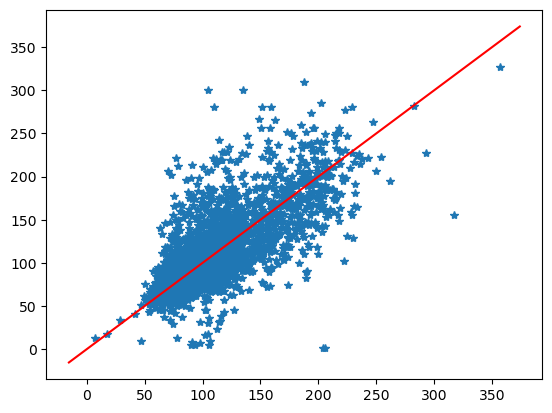

In [30]:
# test
model.eval()
varS = ['VV', 'VH', 'vh_vv']
varL = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'ndvi', 'ndwi', 'nirv']
varM = ['Fpar', 'Lai']
iS = [df.varX.index(var) for var in varS]
iL = [df.varX.index(var) for var in varL]
iM = [df.varX.index(var) for var in varM]
yOut = np.zeros(len(testInd))

for k, ind in enumerate(testInd):
    k
    xS = x[pSLst[ind], ind, :][:, iS][None, ...]
    xL = x[pLLst[ind], ind, :][:, iL][None, ...]
    xM = x[pMLst[ind], ind, :][:, iM][None, ...]
    pS = (pSLst[ind][None, ...] - rho) / rho
    pL = (pLLst[ind][None, ...] - rho) / rho
    pM = (pMLst[ind][None, ...] - rho) / rho
    xcT = xc[ind][None, ...]
    xS = torch.from_numpy(xS).float()
    xL = torch.from_numpy(xL).float()
    xM = torch.from_numpy(xM).float()
    pS = torch.from_numpy(pS).float()
    pL = torch.from_numpy(pL).float()
    pM = torch.from_numpy(pM).float()
    xcT = torch.from_numpy(xcT).float()
    lTup = (xS.shape[1], xL.shape[1], xM.shape[1])
    yP = model((xS, xL, xM), (pS, pL, pM), xcT, lTup)
    yOut[k] = yP.detach().numpy()

yT = yc[testInd, 0]

obs = dm.transOutY(yT[:, None])[:, 0]
pred = dm.transOutY(yOut[:, None])[:, 0]
correlation(obs, pred)

RMSE: 6.228768476019017 | Rsq: 0.5417046798317825


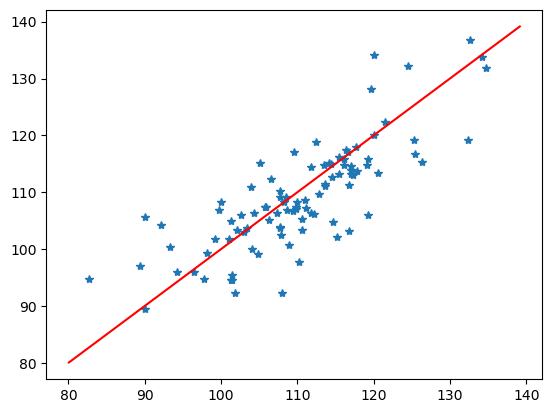

In [31]:
model.eval()

tempS = jInd[testInd]
tempT = iInd[testInd]
testSite = np.unique(tempS)
siteLst = list()
matResult = np.ndarray([len(testSite), 3])

for i, k in enumerate(testSite):
    ind = np.where(tempS == k)[0]
    t = df.t[tempT[ind]]
    siteName = df.siteIdLst[k]
    siteLst.append([pred[ind], obs[ind], t])
    matResult[i, 0] = np.mean(pred[ind])
    matResult[i, 1] = np.mean(obs[ind])
    matResult[i, 2] = np.corrcoef(pred[ind], obs[ind])[0, 1]
    
correlation(matResult[:, 0], matResult[:, 1])

In [32]:
import matplotlib

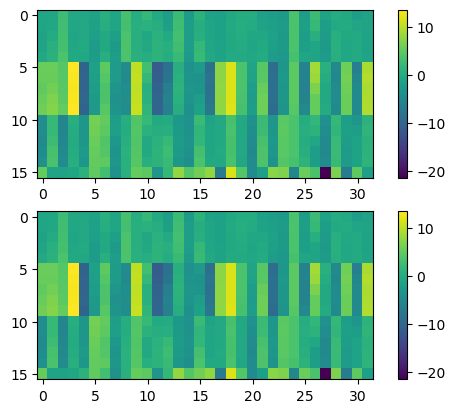

In [33]:
xS = torch.ones(1, 5, 3)
xL = torch.ones(1, 5, 8)
xM = torch.ones(1, 5, 2)
pS = torch.tensor([-1, -0.5, 0, 0.5, 1 ])[None,:]
pL = torch.tensor([-1, -0.5, 0, 0.5, 1 ])[None,:]
pM = torch.tensor([-1, -0.5, 0, 0.5, 1 ])[None,:]
xcT = torch.ones(1, 15)
yP = model((xS, xL, xM), (pS, pL, pM), xcT, (5, 5, 5))
xIn=model.encoder((xS, xL, xM),(pS, pL, pM), xcT)
atten=model.atten
q, k, v = atten.W_q(xIn), atten.W_k(xIn), atten.W_v(xIn)
d = q.shape[1]
score = torch.bmm(q.transpose(1, 2), k) / math.sqrt(d)
fig,axes=plt.subplots(2,1)
im1=axes[0].imshow(k[0,:,:].detach().numpy())
im2=axes[1].imshow(k[0,:,:].detach().numpy())
fig.colorbar(im1)
fig.colorbar(im2)

In [34]:
matplotlib.rcParams.update({'font.size': 11})
matplotlib.rcParams.update({'lines.linewidth': 2})
matplotlib.rcParams.update({'lines.markersize': 12})
matplotlib.rcParams.update({'legend.fontsize': 11})

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

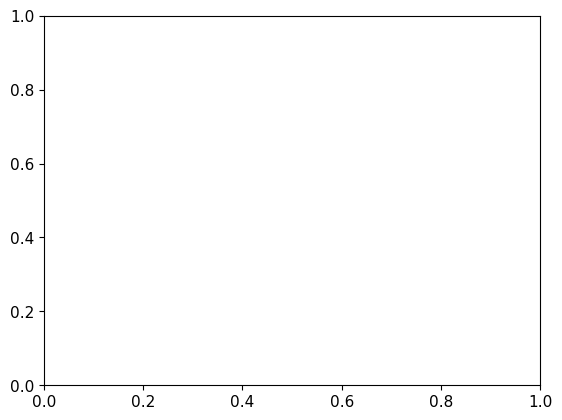

In [46]:
# anomoly
fig, ax = plt.subplots(1, 1)
aLst, bLst = list(), list()
for site_info in siteLst:
    site = site_info[0]
    aLst.append(site[:, 0] - np.mean(site[:, 0]))
    bLst.append(site[:, 1] - np.mean(site[:, 1]))
a, b = np.concatenate(aLst), np.concatenate(bLst)
ax.plot(np.concatenate(aLst), np.concatenate(bLst), '.')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
vmin = np.min([xlim[0], ylim[0]])
vmax = np.max([xlim[1], ylim[1]])
_ = ax.plot([vmin, vmax], [vmin, vmax], 'r-')

In [45]:
siteLst[0]

[array([111.28431141, 189.16540289, 207.81046534,  72.40415442,
         69.37941873,  81.35198331, 113.72212291,  78.25339606,
         76.03814656,  95.01547301,  98.78641009,  98.09381819,
        190.34583914, 194.51905894, 108.17707634,  96.04803491,
        120.52945036,  59.27808928,  83.52845609, 183.53340459,
        212.7261796 , 226.98535717, 104.38379693, 198.98403847,
         96.97052711,  81.66537017,  62.98501128,  89.36290526,
         97.18981028, 104.01324475, 118.80829561, 134.48298734,
         88.04882807,  68.51179013,  73.24467105,  78.5134303 ,
        104.23349494,  72.50757581,  71.40226537,  98.41673428,
         67.84352496,  54.28276664, 113.74906868,  73.00486881,
         67.06387052,  71.77677631, 101.84828562,  93.84402204]),
 array([218., 175., 199., 115.,  68.,  86.,  92.,  74.,  60.,  87.,  97.,
         96., 194., 131.,  94., 103.,  90.,  55.,  88., 100., 185., 210.,
        115., 175., 100.,  93.,  83.,  83.,  95., 102., 152., 123., 135.,
        

In [39]:
ax.plot(matResult[:, 0], matResult[:, 1], '*')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
vmin = np.min([xlim[0], ylim[0]])
vmax = np.max([xlim[1], ylim[1]])
_ = ax.plot([vmin, vmax], [vmin, vmax], 'r-')

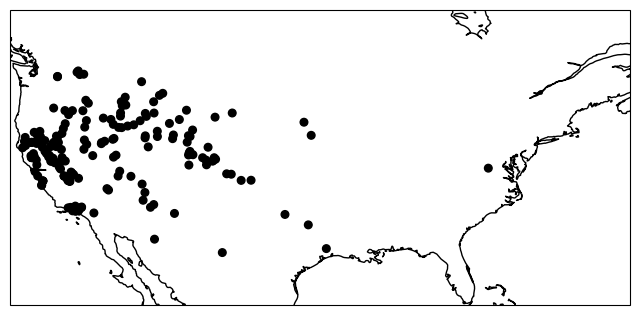

In [40]:
import matplotlib.gridspec as gridspec

trainSite = np.unique(jInd[trainInd])
lat = df.lat[trainSite]
lon = df.lon[trainSite]
figM = plt.figure(figsize=(8, 6))
gsM = gridspec.GridSpec(1, 1)
axM = mapplot.mapPoint(
    figM, gsM[0, 0], lat, lon, np.zeros(len(lat)), cmap='gray', cb=False
)
# figM.show()

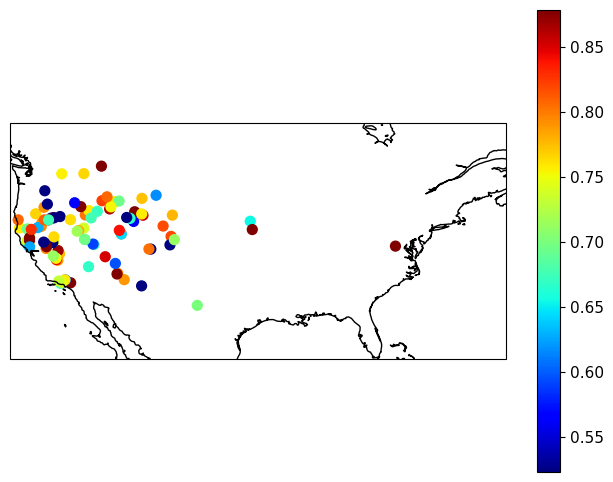

In [41]:
lat = df.lat[testSite]
lon = df.lon[testSite]
figM = plt.figure(figsize=(8, 6))
gsM = gridspec.GridSpec(1, 1)
axM = mapplot.mapPoint(figM, gsM[0, 0], lat, lon, matResult[:, 2], s=50)
# figM.show()

/Users/andyhuynh/Documents/lfmc/geolearn/hydroDL/post/figplot.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figM.show()
/Users/andyhuynh/Documents/lfmc/geolearn/hydroDL/post/figplot.py:75: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figP.show()


(<Figure size 800x600 with 2 Axes>, <Figure size 640x480 with 1 Axes>)

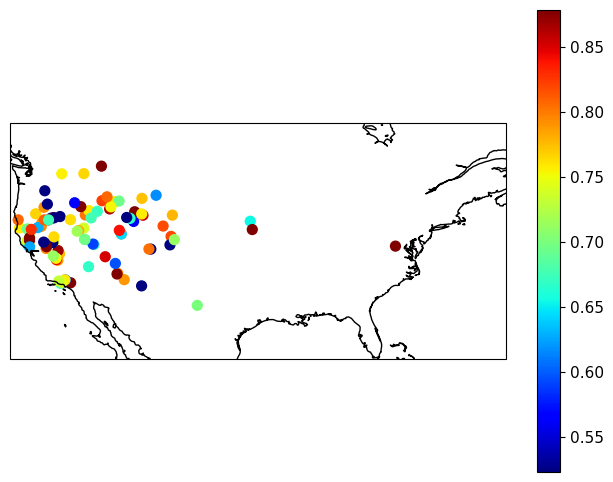

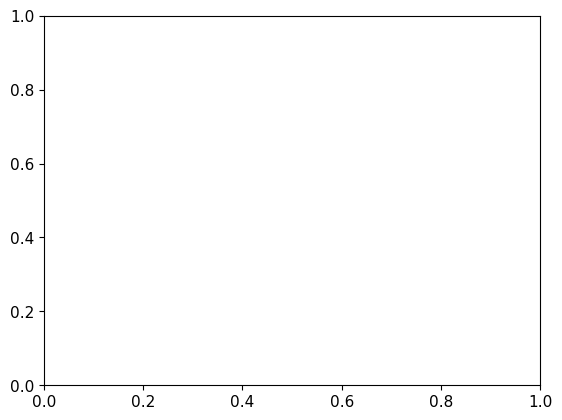

In [42]:
def funcM():
    lat = df.lat[testSite]
    lon = df.lon[testSite]
    figM = plt.figure(figsize=(8, 6))
    gsM = gridspec.GridSpec(1, 1)
    axM = mapplot.mapPoint(figM, gsM[0, 0], lat, lon, matResult[:, 2], s=50)
    figP, axP = plt.subplots(1, 1)
    return figM, axM, figP, axP, lon, lat


def funcP(iP, axP):
    print(iP)
    axP.plot(siteLst[iP][2], siteLst[iP][0], 'r*-', label='pred')
    axP.plot(siteLst[iP][2], siteLst[iP][1], 'b*-', label='obs')
    axP.legend()


figplot.clickMap(funcM, funcP)


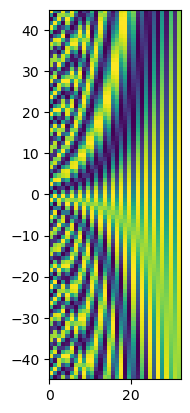

In [8]:
rho = 90
pos = torch.arange(-45, 45, dtype=torch.float32)/45
pos=pos[None,:]
nh=32
P = torch.zeros([pos.shape[0], pos.shape[1], nh], dtype=torch.float32)
for i in range(int(nh / 2)):
    # P[:, :, 2 * i] = torch.sin(pos * (i + 1) * torch.pi)
    # P[:, :, 2 * i + 1] = torch.cos(pos * (i + 1) * torch.pi
    P[:, :, 2 * i] = torch.sin(pos *rho/ 10000**((i + 1)/32) )
    P[:, :, 2 * i + 1] = torch.cos(pos *rho/ 10000**((i + 1)/32) )
fig, ax = plt.subplots(1, 1)
ax.imshow(P[0, :, :].detach().numpy(),extent=[0,32,-45,45])

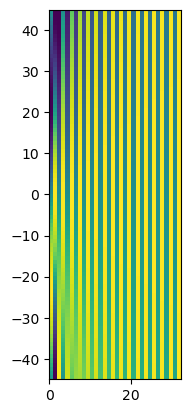

In [9]:
pos = torch.arange(-45, 45, dtype=torch.float32)/45
pos=pos[None,:]
nh=32
P = torch.zeros([pos.shape[0], pos.shape[1], nh], dtype=torch.float32)
for i in range(int(nh / 2)):
    P[:, :, 2 * i] = torch.sin(pos / (i + 1) * torch.pi)
    P[:, :, 2 * i + 1] = torch.cos(pos / (i + 1) * torch.pi)
fig, ax = plt.subplots(1, 1)
ax.imshow(P[0, :, :].detach().numpy(),extent=[0,32,-45,45])